### Import necessary packages

In [4]:
# Install required packages here if needed (remove '#')
#!pip3 install pandas
#!pip3 install pandas_datareader
#!pip3 install datetime

In [5]:
import pandas as pd
import pandas_datareader as web
import datetime
import statsmodels.api as sm

### Functions to import price data

In [6]:
def read_price_data(stock_symbol, start_date, end_date, interval):
    """Import price data from Yahoo Finance"""
    try:
        stock_data = web.get_data_yahoo(stock_symbol, start_date, end_date, interval=interval)
    except:
        return None

    prices = stock_data.loc[:, "Adj Close"] # adjusted for stock splits and dividends
    prices = prices.fillna(method="ffill")

    return prices

In [7]:
def get_date_list(stock_symbol, start_date, end_date, interval):
    """Generate list of trading dates"""
    stock_data = web.get_data_yahoo(stock_symbol, start_date, end_date, interval=interval)
    dates = stock_data.index
    
    return dates

### Generate input table for month on month comparison of a stock against S&P 500

In [8]:
index_symbol = "^GSPC" # Index symbol (by default "^GSPC" for the S&P500 index)
stock_symbol = "BKNG" # <-- Please enter Stock symbol

# Generate list of trading days
start_date = datetime.datetime(2017, 10, 1)
end_date = datetime.datetime(2022, 9, 1)
interval = 'm' 
date_list = get_date_list(index_symbol, start_date, end_date, interval=interval)

# Generate empty dataframe
column_header_index = "Index price ({})".format(index_symbol)
column_header_stock = "Stock price ({})".format(stock_symbol)
df = pd.DataFrame(
        columns=[column_header_index, column_header_stock], index=date_list
    )

# Sort dataframe based on date
df = df.sort_index(ascending=False)  

# Import price series into dataframe
try:
    price_series = read_price_data(index_symbol, start_date, end_date, interval=interval)
    df[column_header_index] = price_series
    
    price_series = read_price_data(stock_symbol, start_date, end_date, interval=interval)
    df[column_header_stock] = price_series  
except:
    print('Import failed')

# Print head of dataframe
df.head()

,Index price (^GSPC),Stock price (BKNG)
Date,,
2022-09-01,3901.350098,1956.770020
2022-08-01,3955.000000,1875.810059
2022-07-01,4130.290039,1935.689941
2022-06-01,3785.379883,1748.989990
2022-05-01,4132.149902,2243.560059


### Calculate monthly returns

In [9]:
#resample based on month, replace null values with value from the previous row, compute percentage change
mtl_ret = df.resample('M').ffill().pct_change() 
mtl_ret = mtl_ret.dropna(axis=0) # get rid of NaN rows
mtl_ret = mtl_ret.sort_index(ascending=False)
mtl_ret.rename(columns = {'Index price (^GSPC)': index_symbol, 'Stock price ('+stock_symbol+')': stock_symbol}, inplace = True)
mtl_ret.head()

,^GSPC,BKNG
Date,,
2022-09-30,-0.013565,0.043160
2022-08-31,-0.042440,-0.030935
2022-07-31,0.091116,0.106747
2022-06-30,-0.083920,-0.220440
2022-05-31,0.000053,0.015043


### Define dependant and independant variable

In [10]:
X = mtl_ret[index_symbol] # independant variable
y = mtl_ret[stock_symbol] # dependant variable

X_sm = sm.add_constant(X) # OLS requires the input to have a column of ones
X_sm.head()

,const,^GSPC
Date,,
2022-09-30,1.0,-0.013565
2022-08-31,1.0,-0.042440
2022-07-31,1.0,0.091116
2022-06-30,1.0,-0.083920
2022-05-31,1.0,0.000053


In [11]:
model = sm.OLS(y, X_sm)

In [12]:
results = model.fit()

In [13]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   BKNG   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.457
Method:                 Least Squares   F-statistic:                     49.72
Date:                Fri, 16 Sep 2022   Prob (F-statistic):           2.61e-09
Time:                        13:02:07   Log-Likelihood:                 76.451
No. Observations:                  59   AIC:                            -148.9
Df Residuals:                      57   BIC:                            -144.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0057      0.009     -0.642      0.524      -0.024       0.012
^GSPC          1.2250      0.174      7.052      0.000       0.877       1.573
==============================================================================
Omnibus:                        0.452   Durbin-Watson:                   2.204
Prob(Omnibus):                  0.798   Jarque-Bera (JB):                0.604
Skew:                           0.091   Prob(JB):                        0.739
Kurtosis:                       2.539   Cond. No.                         19.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Visualization of scatter plot

In [14]:
import seaborn as sns
from matplotlib import pyplot as plt

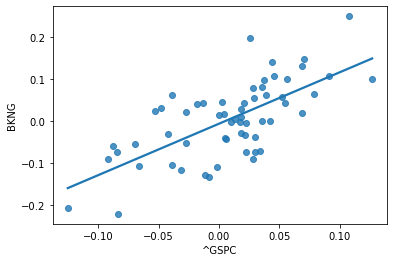

In [15]:
sns.regplot(x=index_symbol, y=stock_symbol, data=mtl_ret, ci = None)
plt.show()